In [1]:
import os
import numpy as np
import mne

/home/jtorretr/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 
                                    'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /home/jtorretr/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


In [5]:
print(raw.info)

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


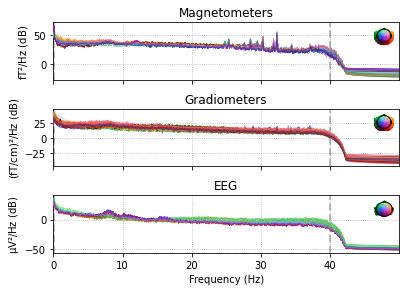

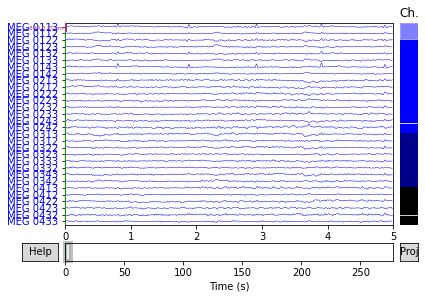

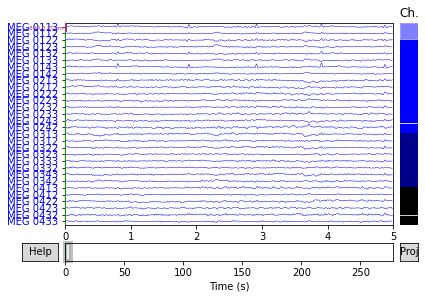

In [7]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 20 components
Fitting ICA took 3.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
138 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
138 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


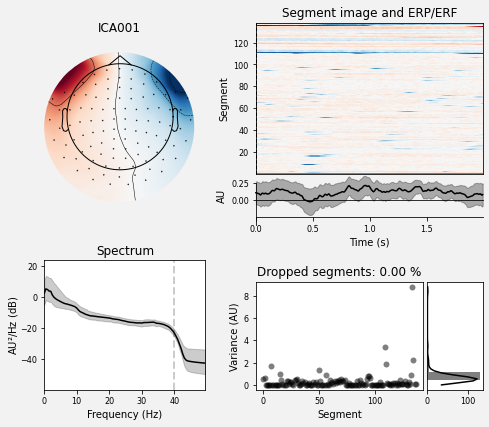

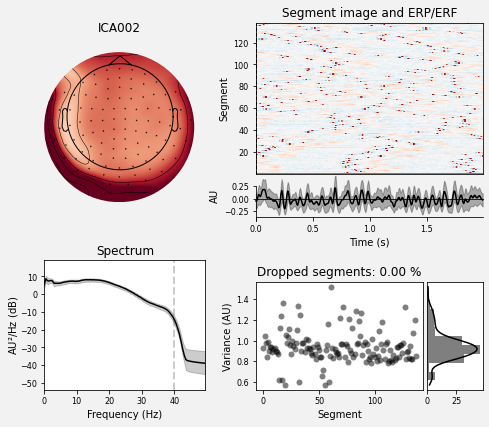

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [9]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Transforming to ICA space (20 components)
Zeroing out 2 ICA components


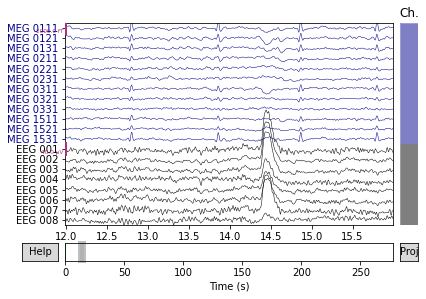

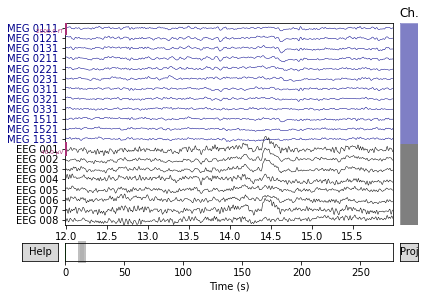

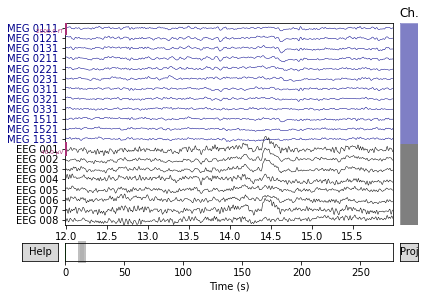

In [10]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

In [11]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [12]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

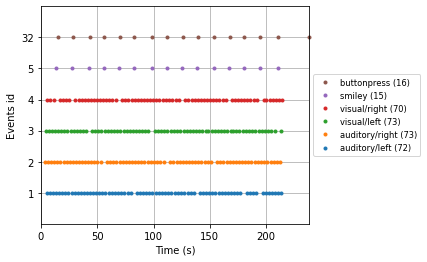

In [13]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

In [14]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

In [15]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

319 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [16]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


136 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
136 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


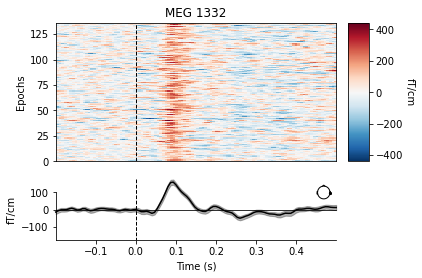

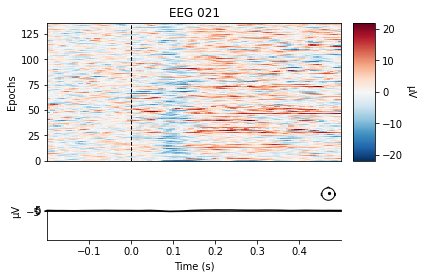

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [19]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021'])

No baseline correction applied


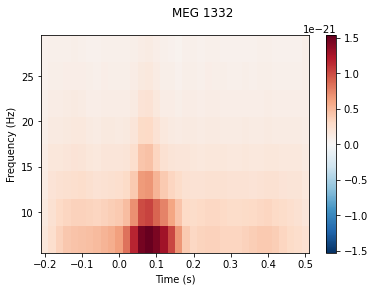

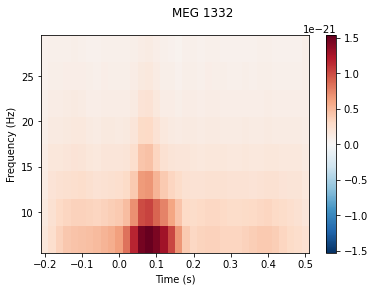

In [20]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


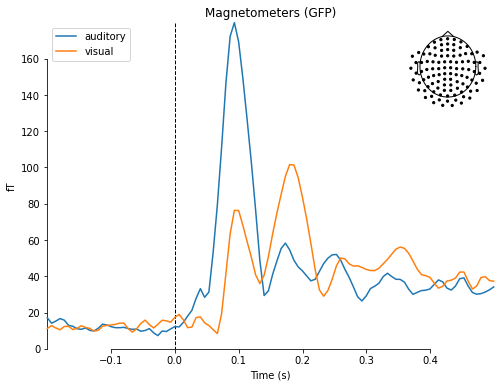

combining channels using "gfp"
combining channels using "gfp"


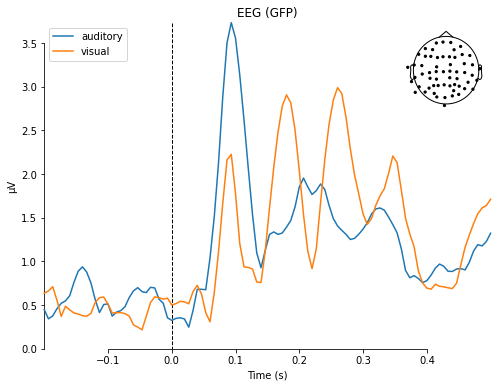

combining channels using "gfp"
combining channels using "gfp"


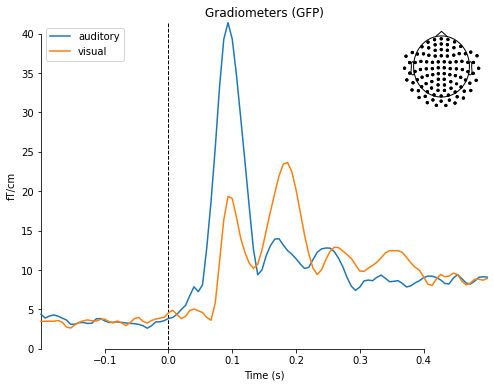

[<Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>]

In [21]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

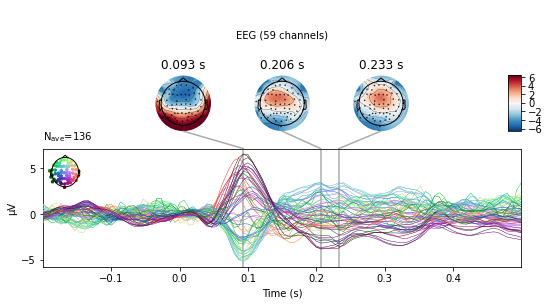

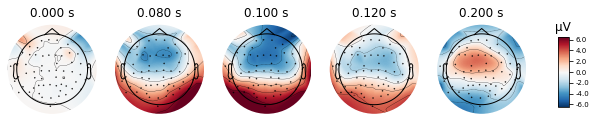

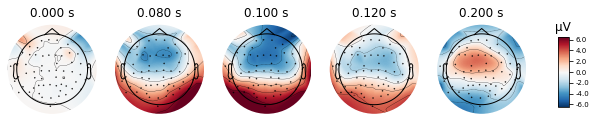

In [23]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

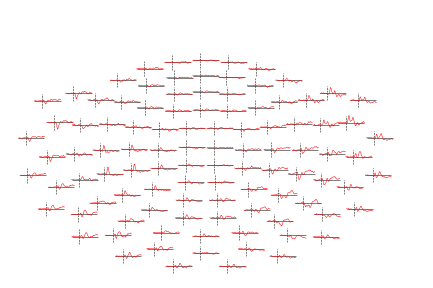

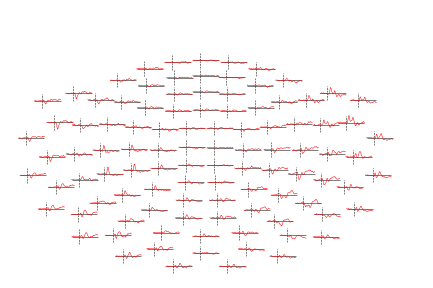

In [24]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(meg='mag').plot_topo(color='r', legend=False)

In [27]:
inverse_operator_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                     'sample_audvis-meg-oct-6-meg-inv.fif')
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)

# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from /home/jtorretr/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing 

In [28]:
# path to subjects' MRI files
subjects_dir = os.path.join(sample_data_folder, 'subjects')
# plot
stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
         subjects_dir=subjects_dir)

Using mayavi 3d backend.

Using control points [8.61922423e-11 1.06837855e-10 4.49139511e-10]
<Brain subject_id="sample", hemi="split", surf="inflated">
